In [1]:

import numpy as np 
import pandas as pd 
import missingno as msno
import matplotlib.pyplot as plt 
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer 
from yellowbrick.classifier import ConfusionMatrix, ClassBalance 
from sklearn.dummy import DummyClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from copy import deepcopy
from sklearn.svm import SVC 
from sklearn.model_selection import (validation_curve, RandomizedSearchCV, 
 learning_curve, GridSearchCV , cross_val_score)
from sklearn.model_selection import KFold, StratifiedKFold , RepeatedStratifiedKFold
from seaborn import boxplot 


#from yellowbrick.classifer import ConfusionMatrix 
import seaborn as sns 
sns.set()
import warnings 
warnings.filterwarnings('ignore') 


In [2]:
#!pip install spicy

In [3]:
origin_df = pd.read_csv("main.bagciv.data_true.csv")
origin_df.head(5)

,num,name,east,north,power,magnitude,shape,type,sfi,ohmS,lwi,geol,flow
0,1,b1,790496,1175071.0,110,136,W,CP,0.388909,1666.165142,32.023585,VOLCANO-SEDIM. SCHISTS,2.5
1,2,b2,791227,1159566.0,70,142,V,EC,1.340127,1135.551531,21.406531,GRANITES,0.8
2,3,b3,774610,1136762.0,80,87,V,EC,0.446594,767.562500,0.000000,GRANITES,1.0
3,4,b4,776778,1128130.0,60,116,W,NC,0.763676,987.943553,28.709623,GRANITES,1.2
4,5,b5,762550,1144126.0,70,111,W,EC,0.068501,769.095833,2.300000,GEOSYN. GRANITES,1.5


In [4]:
#  drop the features num , east, north, lwi and  and set index to name 
df0=origin_df.drop (["num",
                     "east",
                     "north",
                     "lwi"
                     ], axis =1).set_index("name")


In [5]:
colums_order =["shape", "type", "geol", "power", "magnitude", "sfi", "ohmS", "flow"]
df_order= df0[colums_order]


In [6]:
# counter the categorical data 
cat_columns =["shape", "type", "geol"]
dfs = df_order["shape"].value_counts (normalize=True)
dft =df_order["type"].value_counts (normalize=True)
dfg = df_order["geol"].value_counts (normalize=True)

#for df in [dfs, dft, dfg]: 
#    plt.bar (df.index, df)

# j =0
# for i in  range(len(dfs)): 
#     plt.bar (dfs.index[i], dfs.values[i]+ j, bottom = dfs.values[i]+ j)
#     j = dfs.values[i] 



In [7]:
#Vectorisation of features shape, type, geol, and y 

def flowMapping (value): 
    if value == 0. : 
        return 0  #FR0
    elif  0 < value <=1:
        return 1 #FR1
    elif 1 < value <=3:
        return 2  # FR2
    else : return 3  #FR3
def binMapping (value): 
    return 0 if value <=1 else 1 

geomap = {"VOLCANO-SEDIM. SCHISTS":1, 
          "GRANITES":3, 
          "GEOSYN. GRANITES":2, 
          "GNEISS-MIGMATITES":4
          }
mapshape ={"W":1, 
          "U":2, 
          "V":3, 
          "H":4, 
          "K":5, 
          "C":6, 
          "M":7}

maptype ={"EC":1, 
          "NC":2, 
          "CP":3, 
          "CB2P":4
}
def geolMapping(value): 
    if value =="VOLCANO-SEDIM. SCHISTS": 
        return "VOLCS."
    elif value =="GRANITES": 
        return "GRAN."
    elif value =="GEOSYN. GRANITES": 
        return "GEOG."
    elif value =="GNEISS-MIGMATITES":
        return "MIGG."
    
# df_order.geol = df_order["geol"].apply (geolMapping)
df_order.flow=df_order["flow"].apply (flowMapping)
df_order.geol = df_order["geol"].map(geomap)
df_order["shape"]=df_order["shape"].map(mapshape)
df_order.type= df_order.type.map(maptype)
df_binary=df_order.copy()
df_binary.flow = df_binary.flow.apply(binMapping)

#df_order.describe()

In [8]:
# separate two datasets , multiclassification and binary 

dfm = df_order.copy() # multiclassification 
dfb = df_binary.copy() # binary classification 



In [9]:
# targets 
y = dfm.flow 
yb = dfb.flow 

X = dfm.drop (columns= "flow") 
Xb = dfb.drop(columns="flow")


In [10]:
# imput the data 
imp_obj = SimpleImputer (strategy ="median")
X_imp = imp_obj.fit_transform (X)
X_imputed =pd.DataFrame (data=X_imp, columns= X.columns)

In [11]:
# Scaled the numerical data 
num_columns =["power", "magnitude", "sfi", "ohmS"]
X_num_imputed= X_imputed[num_columns]
scaler_obj = StandardScaler () 
X_num_scaled = scaler_obj. fit_transform(X_num_imputed)
#X_cat_imputed= X_imputed[cat_columns]
# concat the 
X = np.c_[dfm[cat_columns].values, X_num_scaled]
X= pd.DataFrame (data=X, columns= dfm.drop(columns="flow").columns)
X.head(5)
X_for_validation = X.copy ()

X_for_validation.set_index(y.index)
X.shape

(431, 7)

In [12]:
# One Hot encoded categorical features 

ohe_obj = OneHotEncoder(categories ="auto", drop="first")
c_transf = ColumnTransformer([ 
                              ("ohe",ohe_obj , [0, 1, 2] ), 
                              ("nothing", "passthrough", [3, 4, 5, 6])
                              ])
Xohe=c_transf.fit_transform(X).astype(float)
Xohe.shape


(431, 14)

In [13]:
# RECAP
X = Xohe.copy()
X, y # Dataset for mutiple classification task 
X, yb #Dataset for binary classification task 
#check the fist row of data 
X.shape

(431, 14)

In [14]:
ycount = y.value_counts(normalize =True)
ybcount =yb.value_counts(normalize =True)
ycount , ybcount 

(2    0.357309
 1    0.354988
 3    0.146172
 0    0.141531
 Name: flow, dtype: float64,
 1    0.50348
 0    0.49652
 Name: flow, dtype: float64)

In [15]:
# stratified sampling 
# multiclassification 

_, _, y_trainno, y_testno=train_test_split (X, y , test_size = 0.2, random_state= 42)
X_train, X_test , y_train, y_test = train_test_split (X, y , test_size = 0.2, random_state= 42, stratify = y)

X_train.shape, X_test.shape , y_train.shape, y_test.shape

((344, 14), (87, 14), (344,), (87,))

In [16]:
# finction to plot class balances 
def plotClassBalances (y, labels, savefig): 
    fig , ax = plt.subplots(figsize=(6, 6))
    cb_bin= ClassBalance (labels =labels)
    cb_bin.fit(y)
    cb_bin.poof()
    fig.savefig(savefig, dpi =300)
    

In [17]:
#Binarry 
Xbtraino, Xb_testno, yb_trainno, yb_testno=train_test_split (X, yb , test_size = 0.2, random_state= 42)
Xb_train, Xb_test , yb_train, yb_test = train_test_split (X, yb , test_size = 0.2, random_state= 42, stratify = yb)

Xb_train.shape, Xb_test.shape , yb_train.shape, yb_test.shape

((344, 14), (87, 14), (344,), (87,))

In [18]:
#RECAP
#multiclassification  Database 
X_train , y_train , X_test, y_test 
# binary classifier 
Xb_train, yb_train, Xb_test, yb_test 
yb.shape

(431,)

In [19]:
# TQUick test with dumy classifier  Baseline Model 
bm = DummyClassifier(random_state=42)
bm.fit(X_train, y_train)
bm.score (X_test, y_test) 

# dumy classifier with Binary 
bmb = DummyClassifier(random_state=42)
bmb.fit(Xb_train, yb_train)
bmb.score (Xb_test, yb_test) 


0.5057471264367817

In [20]:
cv=4

print(X_for_validation.shape)
Xbtrainfv , Xbtestfv , ybtrainfv , ybtestfv = train_test_split (
    X_for_validation.reset_index(drop =True), yb.reset_index (drop =True), test_size =0.2, random_state = 42)

kf =KFold (n_splits=cv, random_state= 42, shuffle=True)   

(431, 7)


In [21]:

# print(Xtrainfv.set_index (ytrainfv.index))
# print( ytrainfv.index )
num_val_samples = len(Xbtrainfv)//cv 
train_data = Xbtrainfv.copy().values 
train_targets = ybtrainfv.copy().values 

def boxPlotFold (cv , trainset , traintarget, samples, savefig, plottrain=True, viz =True ):
    for i in range (cv): 
        val_data = trainset [i * samples: (i+1) * samples]
        val_targets = traintarget [i * samples: (i+1) * samples]
        partial_train_data = np.concatenate(
            [trainset[:i * samples ], 
            trainset[(i+1) * samples:]], 
            axis =0
        )
        
        if viz:
            fig, ax = plt.subplots (figsize =(8, 6))
            
            if plottrain:
                boxplot( data =val_data )
            if not plottrain:
                boxplot( data =val_targets )
            
            if savefig is not None: 
                fig.savefig(savefig +f"{i+1}.png", dpi =300)

In [22]:
#STRATIFIED Fold 
Xbtrainfv , Xbtestfv , ybtrainfv , ybtestfv = train_test_split (
    X_for_validation.reset_index(drop =True), yb.reset_index (drop =True), test_size =0.2, random_state = 42, stratify = y)

num_val_samples = len(Xbtrainfv)//cv 
train_data = Xbtrainfv.copy().values 
train_targets = ybtrainfv.copy().values 

boxPlotFold (cv=4 , trainset=train_data ,
            traintarget = train_targets, 
            samples= num_val_samples, 
            savefig="images/StratifiedFromY",
            plottrain=False, 
            viz=False)

In [23]:
# stratified kfold index 
# mutilcalss
cv_index= StratifiedKFold(n_splits =4)
cv2_index = KFold(n_splits=4, random_state =42 , shuffle =True)

## Binary Classification

In [24]:
cv = list(cv_index.split(Xb_train, yb_train))
cv2 = list(cv2_index.split(Xb_train, yb_train))

(array([0.5       , 0.5       , 0.5       , 0.76744186, 0.8372093 ,
        0.81976744]),
 array([0.51190476, 0.51190476, 0.51190476, 0.51190476, 0.88636364,
        0.90800866]))

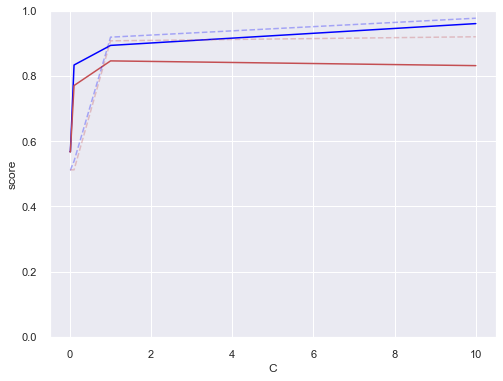

In [25]:
svm0 = SVC()
k_range_paramC = np.power(10 , np.arange(-4, 1.5, dtype =float))
k1 = len(Xb_train)//4
Xbsample = Xb_train [:k1, :]
ybsample = yb_train[:k1]


trainb_score1 , valb_score1 = validation_curve(svm0, Xbsample, ybsample, 
                                         param_name ="C", param_range=k_range_paramC,
                                         cv=4)
trainb_score , valb_score = validation_curve(svm0, Xb_train, yb_train, 
                                         param_name ="C", param_range=k_range_paramC,
                                         cv=4)
fig, ax = plt.subplots (figsize =(8, 6))
ax.plot(k_range_paramC, np.mean(trainb_score, 1), color ="blue", label ="train score")
ax.plot(k_range_paramC, np.mean(valb_score, 1), color ="r", label ="validation score")
ax.plot(k_range_paramC, np.mean(trainb_score1, 1), color ="blue", label ="train score Fold1", alpha =0.3, linestyle ="--")
ax.plot(k_range_paramC, np.mean(valb_score1, 1), color ="r", label ="validation score Fold 1", alpha =0.3, linestyle ="--")
#ax.legend(loc="best")
ax.set_ylim(0, 1)
ax.set_xlabel("C")
ax.set_ylabel("score")


# fig.savefig ("images/valscoreFor1foldand4Fold.png", dpi =300)

np.median(valb_score, 1), np.median(valb_score1, 1)

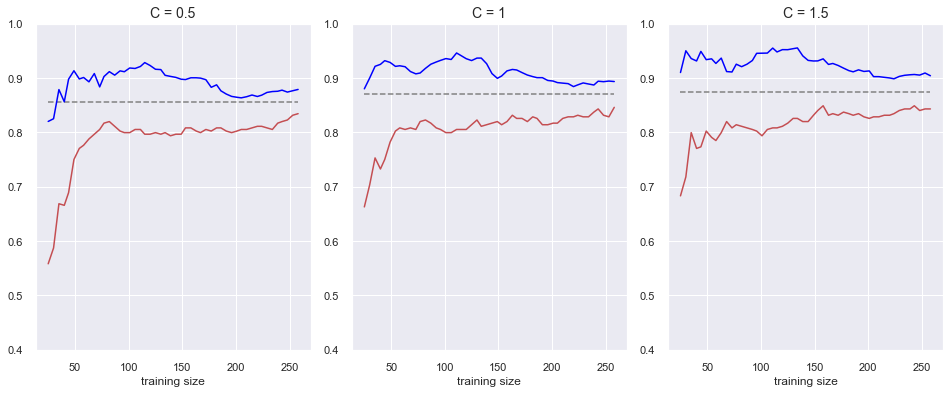

In [26]:
fig, ax = plt.subplots(1, 3, figsize =(16, 6))
fig.subplots_adjust(left=0.0625, right = 0.85, wspace = 0.15)
paramC_test =[0.5, 1, 1.5]
for k, paramc in enumerate(paramC_test): 
    N, trainb_lc , valb_lc = learning_curve(SVC(C=paramc), Xb_train, yb_train, 
                                            train_sizes = np.linspace(0.1, 1, 50),
                                            cv=cv)
    ax[k].plot(N, np.mean(trainb_lc, 1), color ="blue", label ="train score")
    ax[k].plot(N, np.mean(valb_lc, 1), color ="r", label ="validation score")
    ax[k].hlines(np.mean([trainb_lc[-1], valb_lc[-1]]), N[0], N[-1], color="gray", linestyle ="--")
    ax[k].set_ylim(0.4, 1)
    #ax[k].set_xlim (N[0], N[1])
    ax[k].set_xlabel("training size")
    #ax[k].set_ylabel("score")
    ax[k].set_title('C = {0}'.format(paramc), size=14)
    #ax[k].legend(loc="lower left")
    

In [27]:
# Hyperparameters fine-tuning 
kws_bases2 = {
    "C": np.power(10 , np.arange(-4, 4.5,0.5,  dtype =float)), 
    "gamma":np.power(10, np.arange(-7, 1.1,0.5,  dtype =float)), 
    "tol":np.power(10 , np.arange(-4, 1.5,0.5,  dtype =float)), 
    "coef0":np.arange(0, 8),
    "degree":np.arange(1, 8),
}
# kws_bases = {
#     "C": np.power(2 , np.arange(-5, 9,2,  dtype =float)), 
#     "gamma":np.power(2, np.arange(-9, 5,2,  dtype =float)), 
#     "tol":np.power(10 , np.arange(-3, 4, 1,  dtype =float)), 
#     "coef0":np.arange(0, 8),
#     "degree":np.arange(1, 8),
# }

kws_bases = {
    "C": np.power(2 , np.arange(-7, 11,2,  dtype =float)), 
    "gamma":np.power(2, np.arange(-11, 9,2,  dtype =float)), 
    "tol":np.power(10 , np.arange(-3, 4, 1,  dtype =float)), 
    "coef0":np.arange(0, 8),
    "degree":np.arange(1, 8),
}

def generateParams (kernels , params_kws=None): 
    args =[]
    for kernel in kernels : 
        params_kws['kernel'] = [kernel]
        paramgk= deepcopy (params_kws.copy())
        args.append(paramgk)
        del params_kws['kernel']
    
    return args 
param_grids= generateParams(kernels =['poly', 'linear', 'sigmoid', 'rbf'],
params_kws=kws_bases )


In [28]:
def gridSearchSVM (clf, X, y, *,  scoring ='accuracy', param_grid =None,
                    cv =None, nestedcv =True, func = GridSearchCV ): 

    gsobj = func (estimator =clf, 
                   param_grid=param_grid, 
                   scoring =scoring , 
                   cv =cv  , refit=True,
                    n_jobs=-1)
   
    if nestedcv: 
        scores= cross_val_score(gsobj, X, y, scoring =scoring , cv =cv )
        #print(f'{param_grid ["kernel"][0]}: CV accuracy: %3.f +/- %3.f' %(np.mean(scores), np.std(scores)) )
        print(f'{clf.__class__.__name__}: CV accuracy: %3.f +/- %3.f' %(np.mean(scores), np.std(scores)) )
        
    gsobj = gsobj.fit(X, y)
    return gsobj, scores if nestedcv else None

In [29]:
# run all grid searches 

# gridObjs , gridScores ={}, {}
# for param_grid , kernel in zip(param_grids, 
# ['poly', 'linear', 'sigmoid', 'rbf']): 
#     gs , scores= gridSearchSVM (SVC(), X=Xb_train, y=yb_train, 
#      param_grid= param_grid ,
#      cv =cv )
#     print(f" {kernel.capitalize()} - best score:", gs.best_score_ ) 
#     print(f"{kernel.capitalize()} - best params:", gs.best_params_)
#     gridObjs[kernel] = gs 
#     gridScores [kernel]=scores 


In [30]:
try :
    import joblib 
except: pass 

import pickle 

def savef (fn , data ): 
    try : joblib.dump(data, f'{fn}.pkl')
    except : 
        filename +='.pkl'
    with open(fn, 'wb') as wfile: 
        pickle.dump( data, wfile)

# filename = '__svmbinarymodels'
# data = (gridObjs, gridScores)
# try : 
#         joblib.dump(data, f'{filename}.pkl')
# except : 
#     # Now try to pickle data Serializing data 
#     filename +='.pkl'
#     with open(filename, 'wb') as wfile: 
#         pickle.dump( data, wfile)

gridObjs, gridScores = joblib.load('__svmbinarymodels.pkl')

In [31]:
len(gridObjs['sigmoid'].cv_results_['params'])

35280

In [32]:
CV0=4
SVMLinear = gridObjs['linear']
SVMpoly = gridObjs['poly']
SVMrbf = gridObjs['rbf']
SVMsigmoid = gridObjs['sigmoid']

cvres_poly = SVMpoly.cv_results_
cvres_linear= SVMLinear.cv_results_
cvres_rbf= SVMrbf.cv_results_
cvres_sigmoid= SVMsigmoid .cv_results_


SVMs = [SVMLinear, SVMpoly , SVMrbf, SVMsigmoid ] 
SVMsCV_res =[cvres_linear, cvres_poly, cvres_rbf, cvres_sigmoid]

kernels =['Linear', 'Polynomial', 'RBF', 'Sigmoid']


In [33]:

def getGlobalScores(cvres): 
    """ Take the global mean score  and std  test score"""
    return cvres['mean_test_score'].mean() , cvres['std_test_score'].mean()

def getBestForEachSplit(cvres, split=1): 
    if split ==0: split =1 
    split_score = cvres[f'split{split-1}_test_score'] # get the split score 
    # take the max score of the split 
    max_sc = split_score.max() 
    ix_max = split_score.argmax()
    mean_score= split_score.mean()
    # get parm and mean score 
    bests ={'param': cvres['params'][ix_max], 
        'accuracy_score':cvres['mean_test_score'][ix_max], 
        'std_score':cvres['std_test_score'][ix_max],
        f"CV{split}_score": max_sc , 
        f"CV{split}_mean_score": mean_score,
        }

    return bests 


In [34]:
def vizSVModelDetailsMax(cvres ):
    for k in range(CV0):
        print(f'split =CV{k+1}:')
        b= getBestForEachSplit(cvres, split =k)
        print( b)

    globalmeansc , globalstdsc= getGlobalScores(cvres)
    print("Global split scores:")
    print('mean=', globalmeansc , 'std=',globalstdsc)

for kern,  mdetail, model in zip(kernels, SVMsCV_res, SVMs): 
    print(kern, ':')
    vizSVModelDetailsMax(cvres=mdetail)
    print('BestParams: ', model.best_params_)
    print("Best scores:", model.best_score_)
    print()

Linear :
split =CV1:
{'param': {'C': 0.5, 'coef0': 0, 'degree': 1, 'gamma': 0.00048828125, 'kernel': 'linear', 'tol': 0.001}, 'accuracy_score': 0.8313953488372093, 'std_score': 0.054848727511956984, 'CV1_score': 0.9186046511627907, 'CV1_mean_score': 0.7048726467331119}
split =CV2:
{'param': {'C': 0.5, 'coef0': 0, 'degree': 1, 'gamma': 0.00048828125, 'kernel': 'linear', 'tol': 0.001}, 'accuracy_score': 0.8313953488372093, 'std_score': 0.054848727511956984, 'CV1_score': 0.9186046511627907, 'CV1_mean_score': 0.7048726467331119}
split =CV3:
{'param': {'C': 0.5, 'coef0': 0, 'degree': 1, 'gamma': 0.00048828125, 'kernel': 'linear', 'tol': 1.0}, 'accuracy_score': 0.8459302325581396, 'std_score': 0.046055173016729234, 'CV2_score': 0.872093023255814, 'CV2_mean_score': 0.6814322628276117}
split =CV4:
{'param': {'C': 0.125, 'coef0': 0, 'degree': 1, 'gamma': 0.00048828125, 'kernel': 'linear', 'tol': 1.0}, 'accuracy_score': 0.805232558139535, 'std_score': 0.017197906346219802, 'CV3_score': 0.8023255

In [35]:
SVMs = [SVMLinear, SVMpoly , SVMrbf, SVMsigmoid ] 

paramC_test = [ model.best_params_['C'] for model in SVMs ]
paramC_test
hparamLinear =['kernel', 'C', 'tol', ]
hparamPoly =['kernel', 'C', 'tol', 'gamma', 'degree', 'coef0']
hparamrbf =['kernel', 'C', 'tol', 'gamma']
hparamsigmoid =['kernel', 'C', 'tol', 'gamma',  'coef0']
StrParamsList = [hparamLinear , hparamPoly, hparamrbf, hparamsigmoid  ]
temp0=list()
makeParamsStrings =list()
for pstrl, model in zip(StrParamsList  , SVMs ): 
    for k in pstrl: 
        for key , values in model.best_params_.items(): 
            if key ==k :
                try :
                    temp0.append(f'{k} = {round(values, 4)}') 
                except: 
                    temp0.append(f'{k} = {values}') 
    makeParamsStrings .append(', '.join(temp0) )
    temp0=[]
    #fig.savefig (f"images/learninfcurveSVM0_Ceq{paramc}.png", dpi =300)
makeParamsStrings 


['kernel = linear, C = 0.5, tol = 1.0',
 'kernel = poly, C = 128.0, tol = 0.01, gamma = 0.0005, degree = 5, coef0 = 7',
 'kernel = rbf, C = 2.0, tol = 0.001, gamma = 0.125',
 'kernel = sigmoid, C = 512.0, tol = 1.0, gamma = 0.002, coef0 = 0']

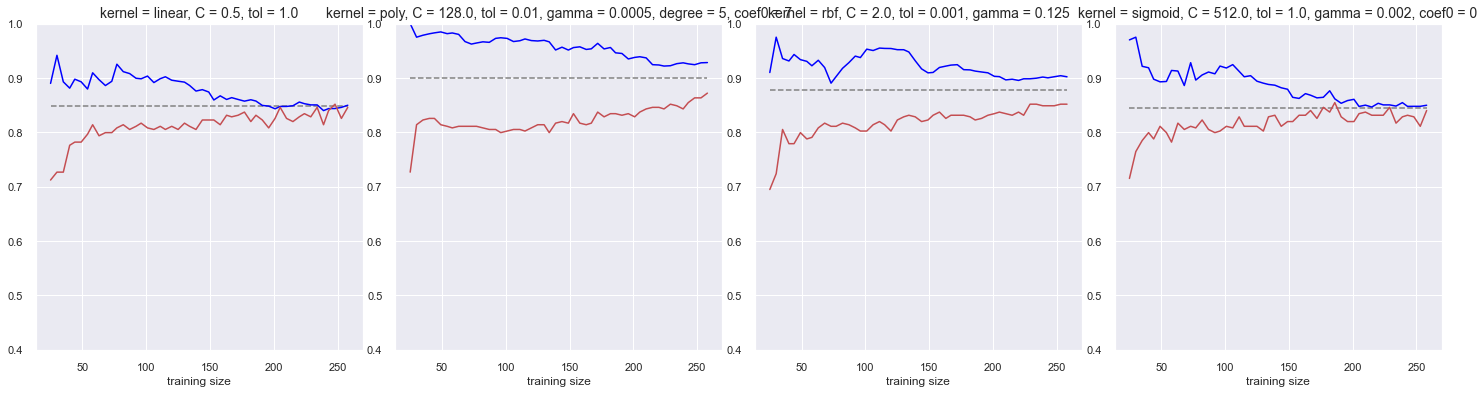

In [36]:
fig, ax = plt.subplots(1, 4, figsize =(22, 6))
fig.subplots_adjust(left=0.0625, right = 0.95, wspace = 0.1)
paramC_test =[0.5, 1, 1.5]

for k, (model, parmL) in enumerate(zip(SVMs, makeParamsStrings)): 
    N, train_lc , val_lc = learning_curve(SVC(**model.best_params_), Xb_train, yb_train, 
                                            train_sizes = np.linspace(0.1, 1, 50),
                                            cv=cv)
    ax[k].plot(N, np.mean(train_lc, 1), color ="blue", label ="train score")
    ax[k].plot(N, np.mean(val_lc, 1), color ="r", label ="validation score")
    ax[k].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color="gray", linestyle ="--")
    ax[k].set_ylim(0.4, 1)
    #ax[k].set_xlim (N[0], N[1])
    ax[k].set_xlabel("training size")
    #ax[k].set_ylabel("score")
    ax[k].set_title(parmL, size=14)
    #ax[k].legend(loc="lower left")



## Model error evaluation 

In [37]:
from sklearn.metrics import (confusion_matrix, accuracy_score, f1_score, average_precision_score, 
                            roc_auc_score, precision_score, recall_score, plot_roc_curve) 
from yellowbrick.classifier import (ROCAUC, PrecisionRecallCurve , ClassPredictionError ,
                         ConfusionMatrix , ClassificationReport)
from sklearn.linear_model import LogisticRegression 

In [38]:
mappingc ={0:'<FR2', 1:'>=FR2'}
classes =['<FR2', '>=FR2']

# Useful functions 
def predictTestSet (model, X): 
    ypred = model.predict(X)
    return ypred 

def visualizeCfxFromSklearn (ytrue, ypred, plot =True, ax=None , annot=True ): 
    mat= confusion_matrix (ytrue, ypred)
    if plot: 
        sns.heatmap (mat.T, square =True, annot =annot,  fmt='d', cbar=False, ax=ax)
        #xticklabels= list(np.unique(ytrue.values)), yticklabels= list(np.unique(ytrue.values)))
        ax.set_xlabel('true labels')
        #ax.set_ylabel ('predicted label')
    return mat 

def visualizeCfxFromYellowbrick (model, XTest, yTest, savefig =None, 
            figsize =(6, 6), labels =classes , label_encoder = mappingc ): 
    fig, ax = plt.subplots(figsize = figsize )
    cm_viz= ConfusionMatrix (model, 
                            classes=labels, 
                        label_encoder = label_encoder, 
                         )
    cm_viz.score(XTest, yTest)
    cm_viz.poof()

    if savefig is not None: 
        fig.savefig(savefig, dpi =300)
    return cm_viz 

def classifReport(model, XTest, yTest, savefig =None, 
            figsize =(6, 3), labels =classes , label_encoder = mappingc): 
    fig, ax = plt.subplots(figsize = figsize )
    cl_viz= ClassificationReport (model, 
                            classes=labels, 
                        label_encoder = label_encoder, 
                         )
    cl_viz.score(XTest, yTest)
    cl_viz.poof()

    if savefig is not None: 
        fig.savefig(savefig, dpi =300)
    return cl_viz 
def rocaucFromYellowbrick(model, XTest, yTest, savefig =None, 
            figsize =(6, 6)): 
    fig, ax = plt.subplots(figsize = figsize )
    roc_viz = ROCAUC(model)
    roc_viz.score(XTest, yTest)
    roc_viz.poof()

    if savefig is not None: 
        fig.savefig(savefig, dpi =300)
    return roc_viz 

def precisionRecallCurveFromYellowbrick(model, X, y,  XTest, yTest,  labels =classes, savefig =None, axis=None, 
            figsize =(6, 4)): 
    #fig, ax = plt.subplots(figsize = figsize )
    prc_viz = PrecisionRecallCurve(model, 
    classes = labels,
     axis =axis )
    prc_viz .fit(X, y)
    prc_viz .score(XTest, yTest)
    prc_viz .poof() 
    if savefig is not None: 
        fig.savefig(savefig, dpi =300)
    return prc_viz  
       
# quick metrics 
def accuracyScore (ytrue, ypred): 
    return accuracy_score (ytrue, ypred)
def recallScore (ytrue, ypred): 
    return recall_score (ytrue, ypred)
def PrecisionScore (ytrue, ypred): 
    return precision_score (ytrue, ypred)
def f1Score (ytrue, ypred): 
    return f1_score (ytrue, ypred)


def classPredictorError(model, XTest, yTest, savefig =None, axis=None, labels =classes, labels_encoder =mappingc, 
            figsize =(6, 6)
             ): 
    fig, ax = plt.subplots(figsize = figsize )
    cpe_viz = ClassPredictionError(model, classes = labels, 
                                    ax =axis,
                                     encoder = labels_encoder
                                     )
    cpe_viz .score(XTest, yTest)
    cpe_viz .poof()

    if savefig is not None: 
        fig.savefig(savefig, dpi =300)
    return cpe_viz 

def averagePrecisionScore (model, X, y): 
    ypred = model.predict(X,)
    return average_precision_score(y, ypred)




Linear : accuracy -score =  0.8390804597701149
Linear : recall -score =  0.8409090909090909
Linear : precision -score =  0.8409090909090909
Linear : ROC AUC-score =  0.8390591966173361
Polynomial : accuracy -score =  0.8390804597701149
Polynomial : recall -score =  0.8409090909090909
Polynomial : precision -score =  0.8409090909090909
Polynomial : ROC AUC-score =  0.8390591966173361
RBF : accuracy -score =  0.8735632183908046
RBF : recall -score =  0.8636363636363636
RBF : precision -score =  0.8837209302325582
RBF : ROC AUC-score =  0.873678646934461
Sigmoid : accuracy -score =  0.8505747126436781
Sigmoid : recall -score =  0.8636363636363636
Sigmoid : precision -score =  0.8444444444444444
Sigmoid : ROC AUC-score =  0.8504228329809724


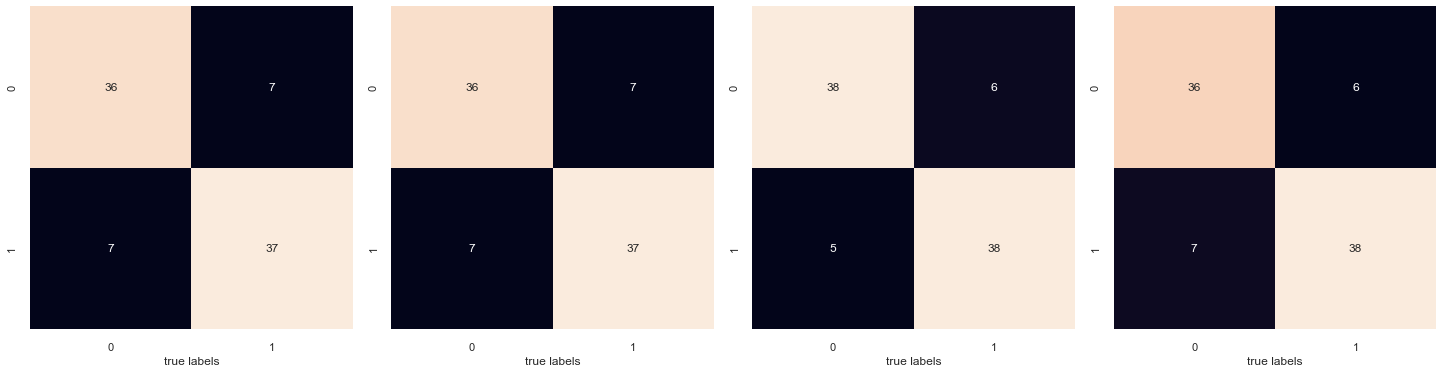

In [39]:
#SVMs = [SVMLinear, SVMpoly , SVMrbf, SVMsigmoid ] 
#kernels =['Linear', 'Polynomial', 'RBF', 'Sigmoid']
fig, ax = plt.subplots(1, 4, figsize =(22, 6))
fig.subplots_adjust(left=0.0625, right = 0.95, wspace = 0.12)

def multipleEvaluationKplus(X,y ,  sklfx =True, yelcfx=False, axis =None, 
                models = SVMs, modelsnames=kernels, annot =True):
    if sklfx : 
        yelcfx=False 
    elif yelcfx: sklfx =False 
    for kk, (svm , kern) in enumerate(zip(models, modelsnames )): 
        ypred = predictTestSet (svm, X)
        acc_scores = accuracy_score(y, ypred)
        print(f"{kern} : accuracy -score = ", acc_scores)
        rec_scores = recall_score(y, ypred)
        print(f"{kern} : recall -score = ", rec_scores)
        prec_scores = precision_score(y, ypred)
        print(f"{kern} : precision -score = ", prec_scores)
        rocauc_scores= roc_auc_score (yb_test, ypred)
        print(f"{kern} : ROC AUC-score = ", rocauc_scores)
        
        if sklfx : 
            visualizeCfxFromSklearn(y, ypred, annot =annot , ax = axis[kk] )
        elif yelcfx:
            visualizeCfxFromYellowbrick(svm, X, y)
        
multipleEvaluationKplus(Xb_test, yb_test, axis =ax )

In [40]:
SVMs_test =deepcopy(SVMs)
# for kk, (svm , kern) in enumerate(zip(SVMs, kernels )): 
#     classPredictorError(svm, Xb_test, yb_test, )

In [41]:
# for kk, (svm , kern) in enumerate(zip(SVMs, kernels )): 
#      precisionRecallCurveFromYellowbrick(svm,Xb_train, yb_train,  Xb_test, yb_test)




In [42]:
# for kk, (svm , kern) in enumerate(zip(SVMs, kernels )): 
#      precisionRecallCurveFromYellowbrick(svm,Xb_train, yb_train,  Xb_test, yb_test , axis =ax[kk])

In [43]:
for kk, (svm , kern) in enumerate(zip(SVMs_test, kernels )): 
    avgprec_scores= averagePrecisionScore (svm, Xb_test, y=yb_test)
    print(f"{kern} : average precision-score = ", avgprec_scores)

Linear : average precision-score =  0.7875878692884963
Polynomial : average precision-score =  0.7875878692884963
RBF : average precision-score =  0.8321790478967704
Sigmoid : average precision-score =  0.7982584465343087


In [44]:
for kk, (svm , kern) in enumerate(zip(SVMs_test, kernels )): 
    ypred = predictTestSet (svm, Xb_test)
    rocauc_scores= roc_auc_score (yb_test, ypred)
    print(f"{kern} : ROC AUC-score = ", rocauc_scores)

Linear : ROC AUC-score =  0.8390591966173361
Polynomial : ROC AUC-score =  0.8390591966173361
RBF : ROC AUC-score =  0.873678646934461
Sigmoid : ROC AUC-score =  0.8504228329809724


Text(0.5, 0.98, 'ROC CURVE comparison')

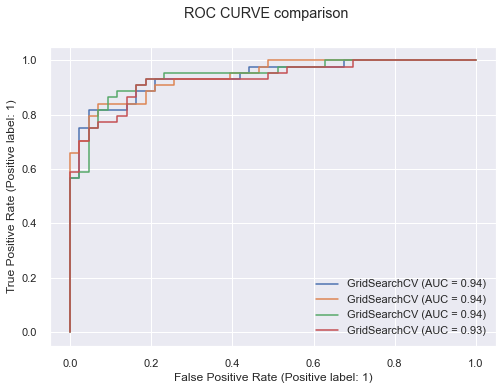

In [45]:
#SVMs = [SVMLinear, SVMpoly , SVMrbf, SVMsigmoid ] 
linbplus = plot_roc_curve(SVMLinear, Xb_test, yb_test)
polybplus = plot_roc_curve(SVMpoly, Xb_test, yb_test, ax= linbplus.ax_)
rbfbplus = plot_roc_curve(SVMrbf, Xb_test, yb_test, ax= linbplus.ax_)
sigbplus = plot_roc_curve(SVMsigmoid, Xb_test, yb_test, ax= linbplus.ax_)

sigbplus.figure_.suptitle('ROC CURVE comparison')

## rbfplus vs logistic regression 

In [46]:
logreg= LogisticRegression (C=1.0, penalty= 'l2', random_state=42)
logreg.fit(Xb_train, yb_train)


LogisticRegression(random_state=42)

RBF+ : accuracy -score =  0.8735632183908046
RBF+ : recall -score =  0.8636363636363636
RBF+ : precision -score =  0.8837209302325582
RBF+ : ROC AUC-score =  0.873678646934461
LOGREG : accuracy -score =  0.8620689655172413
LOGREG : recall -score =  0.8409090909090909
LOGREG : precision -score =  0.8809523809523809
LOGREG : ROC AUC-score =  0.8623150105708245


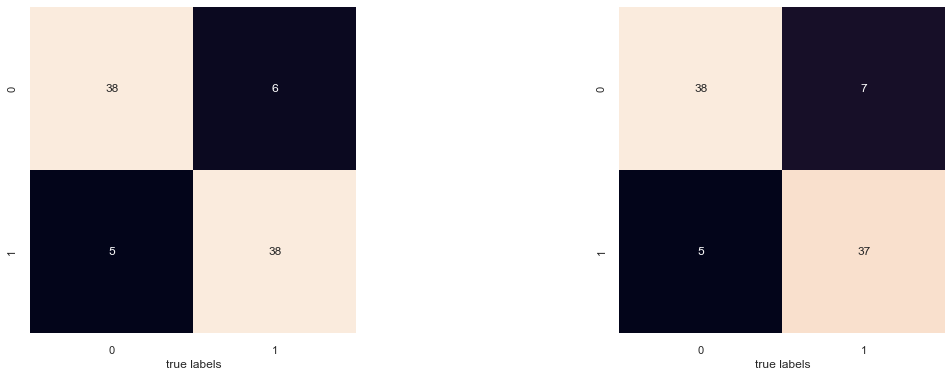

In [47]:
fig, ax = plt.subplots(1, 2, figsize =(18, 6))
fig.subplots_adjust(left=0.0625, right = 0.95, wspace = 0.05)

# for kk, (model , name) in enumerate(zip(, ['RBF+', 'LOGREG'] )): 
#     ypred = predictTestSet (model, Xb_test)
    
#     rocauc_scores= roc_auc_score (yb_test, ypred)
#     print(f"{name} : ROC AUC-score = ", rocauc_scores)

multipleEvaluationKplus(Xb_test, yb_test, sklfx =True, axis =ax, annot =True, 
                models = [SVMrbf,logreg] , modelsnames= ['RBF+', 'LOGREG'] )

Text(0.5, 0.98, 'ROC CURVE comparison')

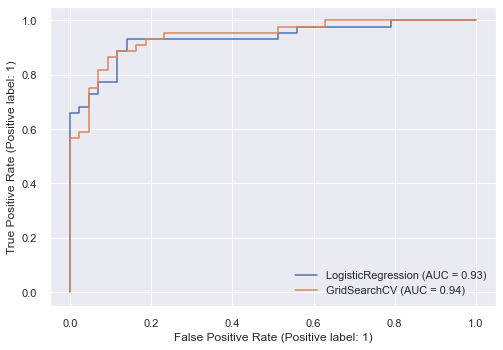

In [48]:
#SVMs = [SVMLinear, SVMpoly , SVMrbf, SVMsigmoid ] 
logregplus = plot_roc_curve(logreg, Xb_test, yb_test)
rbfbplus = plot_roc_curve(SVMrbf, Xb_test, yb_test, ax= logregplus.ax_)


sigbplus.figure_.suptitle('ROC CURVE comparison')

## Ensemble learnings 

In [54]:
from sklearn.ensemble import (
                           RandomForestClassifier ,
                           VotingClassifier, 
                           BaggingClassifier,
                           StackingClassifier,
                           AdaBoostClassifier
) 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier 
from xgboost import XGBClassifier 

In [55]:
# param grid with will all base learners 

lr_params = {
    "C": np.power(10 , np.arange(-3, 4,  dtype =float)), 
    "penalty":['l1', 'l2'], 

}
knn_params ={
    "n_neighbors":np.arange(2, 11), 
    "metric": ['minkowski', 'manhattan'], 
    "p":[1, 2]
}

dt_params = {
    "criterion":["gini", "entropy"],
    "max_depth":np.arange(2, 21), 
    "n_estimators": np.array(list (50 * x for x in np.arange(1, 11))),
     }

lr_params, knn_params, rf_params, dt_params

({'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
  'penalty': ['l1', 'l2']},
 {'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
  'metric': ['minkowski', 'manhattan'],
  'p': [1, 2]},
 {'bootstrap': [True],
  'criterion': ['gini', 'entropy'],
  'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20]),
  'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])},
 {'criterion': ['gini', 'entropy'],
  'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20]),
  'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])},
 {'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20]),
  'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
         0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ]),
  'n_estimators': array([ 50, 100, 150, 200, 25

In [56]:
rs=42
# get pSVM 
pSVM = SVC ( C= 2.0 , kernel ='rbf', gamma = 0.1250, tol = 1.e-03) 
#################################################
bsi_params =[lr_params, knn_params , dt_params] 

bsi =[LogisticRegression (random_state=rs), KNeighborsClassifier(), DecisionTreeClassifier (random_state=rs)] 
bsi_names = ['lr', "knn", "dt"] 



In [57]:
# run all grid searches 
bsigridObjs , bsigridScores ={}, {}
for param_grid , clf , name in zip(bsi_params, bsi , bsi_names): 
    gs , scores= gridSearchSVM (clf, X=Xb_train, y=yb_train, 
     param_grid= param_grid , cv =cv )
    print(f" {name.capitalize()} - best score:", gs.best_score_ ) 
    print(f"{name.capitalize()} - best params:", gs.best_params_)
    bsigridObjs[name] = gs 
    bsigridScores [name]=scores 

bsidata = (bsigridObjs, bsigridScores)

savef(data = bsidata , fn ='init_base_learners' )

LogisticRegression: CV accuracy: nan +/- nan
 Lr - best score: 0.8372093023255814
Lr - best params: {'C': 1.0, 'penalty': 'l2'}
KNeighborsClassifier: CV accuracy: nan +/- nan
 Knn - best score: 0.8023255813953488
Knn - best params: {'metric': 'minkowski', 'n_neighbors': 9, 'p': 1}
DecisionTreeClassifier: CV accuracy: nan +/- nan


In [ ]:
# run all grid searche
#base_learners = []
# gridObjs , gridScores ={}, {}
# for param_grid , kernel in zip(param_grids, 
# ['poly', 'linear', 'sigmoid', 'rbf']): 
#     gs , scores= gridSearchSVM (SVC(), X=Xb_train, y=yb_train, 
#      param_grid= param_grid ,
#      cv =cv )
#     print(f" {kernel.capitalize()} - best score:", gs.best_score_ ) 
#     print(f"{kernel.capitalize()} - best params:", gs.best_params_)
#     gridObjs[kernel] = gs 
#     gridScores [kernel]=scores 
def plotLearningCurves(meta, CVmodels, param_names =None): 
    if param_names is not None: 
        if len(meta) != len(CVmodels) : param_names  = None 
    if param_names is None: 
        param_names = [' ' for i in range(len(CVmodels))]
    fig, ax = plt.subplots(1, 4, figsize =(22, 6))
    fig.subplots_adjust(left=0.0625, right = 0.95, wspace = 0.1)

    for k, (mod, model, parmL) in enumerate(zip(meta, CVmodels,  param_names)): 
        N, train_lc , val_lc = learning_curve(mod(**model.best_params_), Xb_train, yb_train, 
                                                train_sizes = np.linspace(0.1, 1, 50),
                                                cv=cv)
        ax[k].plot(N, np.mean(train_lc, 1), color ="blue", label ="train score")
        ax[k].plot(N, np.mean(val_lc, 1), color ="r", label ="validation score")
        ax[k].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color="gray", linestyle ="--")
        ax[k].set_ylim(0.4, 1)
        #ax[k].set_xlim (N[0], N[1])
        ax[k].set_xlabel("training size")
        #ax[k].set_ylabel("score")
        ax[k].set_title(parmL, size=14)


[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10. ]


array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ])

In [ ]:
bsi_names = ['lr', "knn", "dt", "pSVM"] 
LRc = bsigridObjs['lr']
KNNc=  bsigridObjs['knn']
#SVMrbf = gridObjs['rbf']
DTc = gridObjs['dt']

cvres_LRc = LRc.cv_results_
cvres_KNNc= KNNc.cv_results_
#cvres_rbf= SVMrbf.cv_results_
cvres_DTc= DTc.cv_results_


base_learners= [LRc, KNNc , DTc , SVMrbf ] 
base_learners_meta = [LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier, SVC]
SVMsCV_res =[cvres_LRc, cvres_KNNc,  cvres_DTc, cvres_rbf]

base_learners_names = ['lr', "knn", "dt", "pSVM"] 

plotLearningCurves( meta= base_learners_meta, CVmodels= base_learners , param_names= base_learners_names )


In [ ]:
for name,  mdetail, model in zip(base_learners_names, SVMsCV_res, base_learners): 
    print(name, ':')
    vizSVModelDetailsMax(cvres=mdetail)
    print('BestParams: ', model.best_params_)
    print("Best scores:", model.best_score_)
    print()

### Ensemble params 


In [ ]:

BL = [meta(**param.best_params_) for meta, param in zip(base_learners_meta, base_learners_meta)]
# VOTTING classifier 

# Voting_clf = VotingClassifier( estimators = [
#         ('lr',LRc.best_params_ ),
#         ('knn', KNNc.best_params_),
#         ('dt', DTc.best_params_), 
#         ('pSVM', SVMrbf.best_params_)
# ], voting ='hard'
# )
########################### BENCHMARK 0 ###############################################
voting_params={
    "estimators": [('lr',LRc.best_params_ ),('knn', KNNc.best_params_),('dt', DTc.best_params_), ('pSVM', SVMrbf.best_params_)],
    "voting": ["hard"]
    
}
########################### BAGING AND PASTING ################################
# rf (BAGGING) 
rf_params ={
    "bootstrap":[True],
    "criterion":["gini", "entropy"],
    "max_depth":np.arange(2, 21), 
    "n_estimators": np.array(list (50 * x for x in np.arange(1, 11))), 
}

# PASTING
past_params = {
     "bootstrap":[False],
    "criterion":["gini", "entropy"],
    "max_depth":np.arange(2, 21), 
    "n_estimators": np.array(list (50 * x for x in np.arange(1, 11))), 
 }
#################################### BOOSTING ###############################
#xgboost 
xgboot_params={
    "max_depth":np.arange(2, 21),
    "learning_rate":np.array(list(x/100 for x in range (1, 21, 2))), 
    "n_estimators": np.array(list (50 * x for x in np.arange(1, 11))), 
    "gamma": np.arange(0, 21)/2, 
    "booster":['gbtree']#'gblinear', 'dart'],
}
# adaboost 
AdaBoostClassifier()
ada_params ={
    "base_estimator":BL,
    "n_estimators": np.array(list (50 * x for x in np.arange(1, 11))),
    "learning_rate":np.array(list(x/100 for x in range (1, 21, 2))), 
}
################### STACKING ############################################
StackingClassifier()
stc_params ={
    "estimators":BL,
    "final_estimator":[DTc],
    "cv":cv
}

ensembles =[VotingClassifier , RandomForestClassifier , BaggingClassifier, AdaBoostClassifier, XGBClassifier, StackingClassifier]
ensembles_names = ['vot', 'rf', 'past', 'ada', 'xgboost', 'stc']
ensembles_params =[voting_params, rf_params, past_params, ada_params, xgboot_params, stc_params]


In [ ]:
def gridSearch (clf, X, y, *,  scoring ='accuracy', param_grid =None,
                    cv =None, nestedcv =True, func = GridSearchCV ): 

    gsobj = func (estimator =clf, 
                   param_grid=param_grid, 
                   scoring =scoring , 
                   cv =cv  , refit=True,
                    n_jobs=-1)
   
    if nestedcv: 
        scores= cross_val_score(gsobj, X, y, scoring =scoring , cv =cv )
        #print(f'{param_grid ["kernel"][0]}: CV accuracy: %3.f +/- %3.f' %(np.mean(scores), np.std(scores)) )
        print(f'{clf.__class__.__name__}: CV accuracy: %3.f +/- %3.f' %(np.mean(scores), np.std(scores)) )
        
    gsobj = gsobj.fit(X, y)
    return gsobj, scores if nestedcv else None

In [ ]:
# run all grid searches 
ensgridObjs , ensgridScores ={}, {}
for param_grid , clf , name in zip(ensembles_params, ensembles , ensembles_names ): 
    gs , scores= gridSearch (clf (), X=Xb_train, y=yb_train, func = RandomizedSearchCV , 
     param_grid= param_grid , cv =cv ) 
    print(f" {name.capitalize()} - best score:", gs.best_score_ ) 
    print(f"{name.capitalize()} - best params:", gs.best_params_)
    ensgridObjs[name] = gs 
    ensgridScores [name]=scores 

ensemble_data = (ensgridObjs, ensgridScores)

savef(data = ensemble_data  , fn ='ensemble_learning_' )

In [ ]:

vot_clf= bsigridObjs['vot']
rf_clf=  bsigridObjs['rf']
past_clf = gridObjs['past']
ada_clf=  bsigridObjs['ada']
xgb_clf = gridObjs['xgboost']
stc_clf=  bsigridObjs['stc']

cvres_vot = vot_clf.cv_results_
cvres_rf= rf_clf.cv_results_
cvres_past = past_clf.cv_results_
cvres_ada = ada_clf.cv_results_
cvres_xgb= xgb_clf.cv_results_
cvres_stc= stc_clf.cv_results_

ensemble_clfs = [vot_clf, rf_clf, past_clf , ada_clf, xgb_clf, stc_clf ] 
SVMsCV_res =[cvres_vot, cvres_rf,  cvres_past, cvres_ada,cvres_xgb, cvres_stc ]

plotLearningCurves( meta= ensembles, CVmodels=ensemble_clfs , param_names= ensembles_names )


In [ ]:
for name,  mdetail, model in zip(ensembles_names, SVMsCV_res, ensemble_clfs): 
    print(name, ':')
    vizSVModelDetailsMax(cvres=mdetail)
    print('BestParams: ', model.best_params_)
    print("Best scores:", model.best_score_)
    print()